Direct damages calculation for CI Adapt

In [1]:
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import datetime
from ci_adapt_utilities import *
import pickle
import os
from matplotlib import pyplot as plt

Load default configuration and parameters

In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

Read risk data (asset exposure, vulnerability, hazard)

In [3]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = preprocess_assets(assets_path)
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

122720 assets loaded.


In [4]:
# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [5]:
# Read hazard data (Rauthe M, et al. (2020): Climate impact analysis of the federal transport system in the context of floods: Final report of the key topic flood risks (SP-103) in topic area 1 of the BMVI expert network. 136 pages. DOI: 10.5675/ExpNRM2020.2020.04)
n_drive_dpath=Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps')
# local_haz_path=data_path/r'Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries'
hazard_data_list = ds.read_hazard_data(n_drive_dpath, hazard_type, country=country_name, subfolders=None)#hazard_data_subfolders)
print(f'Found {len(hazard_data_list)} hazard maps.')

Found 183 hazard maps.


In [6]:
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
rp_spec_priority = set_rp_priorities(return_period_dict)

Overlay hazard and asset data

In [7]:
# Calculate direct damage by asset (Koks. E.E. (2022). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict, asset_options=asset_options, rp_spec_priority=rp_spec_priority)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2024-09-20 16:04:13 - Reading hazard map 1 of 183: flood_DERP_RW_H_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410170.geojson
2024-09-20 16:04:19 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [00:01<00:00, 27.62it/s]


2024-09-20 16:05:50 - Reading hazard map 2 of 183: flood_DERP_RW_H_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410430.geojson
2024-09-20 16:05:53 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


2024-09-20 16:06:46 - Reading hazard map 3 of 183: flood_DERP_RW_H_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410540.geojson
2024-09-20 16:06:52 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:00<00:00, 21.28it/s]


2024-09-20 16:08:58 - Reading hazard map 4 of 183: flood_DERP_RW_H_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410660.geojson
2024-09-20 16:09:00 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:00<00:00, 3332.25it/s]


2024-09-20 16:09:04 - Reading hazard map 5 of 183: flood_DERP_RW_H_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410760.geojson
2024-09-20 16:09:15 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 1501.00it/s]


2024-09-20 16:10:26 - Reading hazard map 6 of 183: flood_DERP_RW_H_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080411370.geojson
2024-09-20 16:10:30 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


2024-09-20 16:12:00 - Reading hazard map 7 of 183: flood_DERP_RW_H_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080416200.geojson
2024-09-20 16:12:15 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 1000.07it/s]


2024-09-20 16:16:51 - Reading hazard map 8 of 183: flood_DERP_RW_H_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080416210.geojson
2024-09-20 16:17:00 - Coarse overlay of hazard map with assets...


100%|██████████| 24/24 [01:14<00:00,  3.12s/it]


2024-09-20 16:23:03 - Reading hazard map 9 of 183: flood_DERP_RW_H_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418600.geojson
2024-09-20 16:23:27 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [01:49<00:00,  2.66s/it]


2024-09-20 16:41:18 - Reading hazard map 10 of 183: flood_DERP_RW_H_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418720.geojson
2024-09-20 16:41:19 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


2024-09-20 16:41:19 - Reading hazard map 11 of 183: flood_DERP_RW_H_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418880.geojson
2024-09-20 16:41:26 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00,  6.90it/s]


2024-09-20 16:42:35 - Reading hazard map 12 of 183: flood_DERP_RW_H_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418890.geojson
2024-09-20 16:42:42 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [01:43<00:00, 14.85s/it]


2024-09-20 16:47:36 - Reading hazard map 13 of 183: flood_DERP_RW_H_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080419070.geojson
2024-09-20 16:47:37 - Coarse overlay of hazard map with assets...


100%|██████████| 1/1 [00:00<00:00, 1009.22it/s]


2024-09-20 16:47:37 - Reading hazard map 14 of 183: flood_DERP_RW_H_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080419180.geojson
2024-09-20 16:47:43 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:22<00:00,  1.21s/it]


2024-09-20 16:49:11 - Reading hazard map 15 of 183: flood_DERP_RW_H_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080420240.geojson
2024-09-20 16:49:40 - Coarse overlay of hazard map with assets...


100%|██████████| 62/62 [08:51<00:00,  8.57s/it]


2024-09-20 17:31:38 - Reading hazard map 16 of 183: flood_DERP_RW_H_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080420340.geojson
2024-09-20 17:31:41 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00, 2491.86it/s]


2024-09-20 17:32:13 - Reading hazard map 17 of 183: flood_DERP_RW_H_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080421680.geojson
2024-09-20 17:32:33 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [00:12<00:00,  3.24it/s]


2024-09-20 17:59:42 - Reading hazard map 18 of 183: flood_DERP_RW_H_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080421770.geojson
2024-09-20 17:59:54 - Coarse overlay of hazard map with assets...


100%|██████████| 22/22 [00:03<00:00,  5.84it/s]


2024-09-20 18:22:44 - Reading hazard map 19 of 183: flood_DERP_RW_H_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428080.geojson
2024-09-20 18:22:54 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 18:23:55 - Reading hazard map 20 of 183: flood_DERP_RW_H_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428160.geojson
2024-09-20 18:24:12 - Coarse overlay of hazard map with assets...


100%|██████████| 8/8 [02:17<00:00, 17.25s/it]


2024-09-20 18:31:18 - Reading hazard map 21 of 183: flood_DERP_RW_H_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428500.geojson
2024-09-20 18:31:19 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 18:31:24 - Reading hazard map 22 of 183: flood_DERP_RW_H_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429430.geojson
2024-09-20 18:31:26 - Coarse overlay of hazard map with assets...


100%|██████████| 12/12 [00:00<00:00, 15.06it/s]


2024-09-20 18:32:12 - Reading hazard map 23 of 183: flood_DERP_RW_H_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429540.geojson
2024-09-20 18:32:23 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


2024-09-20 18:40:45 - Reading hazard map 24 of 183: flood_DERP_RW_H_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429670.geojson
2024-09-20 18:40:46 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 18:40:46 - Reading hazard map 25 of 183: flood_DERP_RW_H_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429770.geojson
2024-09-20 18:40:46 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:00<00:00, 75.63it/s]


2024-09-20 18:40:46 - Reading hazard map 26 of 183: flood_DERP_RW_H_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080430240.geojson
2024-09-20 18:40:49 - Coarse overlay of hazard map with assets...


100%|██████████| 17/17 [00:03<00:00,  4.90it/s]


2024-09-20 18:41:55 - Reading hazard map 27 of 183: flood_DERP_RW_H_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080430320.geojson
2024-09-20 18:41:59 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


2024-09-20 18:42:57 - Reading hazard map 28 of 183: flood_DERP_RW_H_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431110.geojson
2024-09-20 18:42:59 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 18:43:11 - Reading hazard map 29 of 183: flood_DERP_RW_H_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431660.geojson
2024-09-20 18:43:22 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


2024-09-20 18:46:38 - Reading hazard map 30 of 183: flood_DERP_RW_H_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431750.geojson
2024-09-20 18:46:50 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 18:47:44 - Reading hazard map 31 of 183: flood_DERP_RW_H_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080432400.geojson
2024-09-20 18:47:47 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


2024-09-20 18:48:06 - Reading hazard map 32 of 183: flood_DERP_RW_H_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080432510.geojson
2024-09-20 18:48:22 - Coarse overlay of hazard map with assets...


100%|██████████| 16/16 [00:01<00:00, 10.66it/s]


2024-09-20 18:56:34 - Reading hazard map 33 of 183: flood_DERP_RW_H_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433520.geojson
2024-09-20 18:56:36 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 18:56:41 - Reading hazard map 34 of 183: flood_DERP_RW_H_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433740.geojson
2024-09-20 18:57:04 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 19:04:53 - Reading hazard map 35 of 183: flood_DERP_RW_H_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433960.geojson
2024-09-20 19:05:25 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 19:09:40 - Reading hazard map 36 of 183: flood_DERP_RW_H_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434150.geojson
2024-09-20 19:09:44 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 19:09:48 - Reading hazard map 37 of 183: flood_DERP_RW_H_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434280.geojson
2024-09-20 19:09:52 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


2024-09-20 19:10:18 - Reading hazard map 38 of 183: flood_DERP_RW_H_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434470.geojson
2024-09-20 19:10:42 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [02:04<00:00,  3.66s/it] 


2024-09-20 19:22:41 - Reading hazard map 39 of 183: flood_DERP_RW_H_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434490.geojson
2024-09-20 19:22:48 - Coarse overlay of hazard map with assets...


100%|██████████| 35/35 [00:00<00:00, 63.06it/s]


2024-09-20 19:24:47 - Reading hazard map 40 of 183: flood_DERP_RW_H_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434630.geojson
2024-09-20 19:25:03 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


2024-09-20 20:36:26 - Reading hazard map 41 of 183: flood_DERP_RW_H_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080435040.geojson
2024-09-20 20:36:59 - Coarse overlay of hazard map with assets...


100%|██████████| 58/58 [00:09<00:00,  6.18it/s]


2024-09-20 21:14:49 - Reading hazard map 42 of 183: flood_DERP_RW_H_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080435320.geojson
2024-09-20 21:14:59 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


2024-09-20 21:17:20 - Reading hazard map 43 of 183: flood_DERP_RW_H_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436660.geojson
2024-09-20 21:17:24 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 21:17:31 - Reading hazard map 44 of 183: flood_DERP_RW_H_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436860.geojson
2024-09-20 21:17:31 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 21:17:32 - Reading hazard map 45 of 183: flood_DERP_RW_H_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436870.geojson
2024-09-20 21:17:33 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 21:17:33 - Reading hazard map 46 of 183: flood_DERP_RW_H_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437100.geojson
2024-09-20 21:17:38 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:23<00:00,  5.76s/it]


2024-09-20 21:19:22 - Reading hazard map 47 of 183: flood_DERP_RW_H_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437230.geojson
2024-09-20 21:19:32 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


2024-09-20 21:23:09 - Reading hazard map 48 of 183: flood_DERP_RW_H_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437370.geojson
2024-09-20 21:23:14 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 1500.47it/s]


2024-09-20 21:23:59 - Reading hazard map 49 of 183: flood_DERP_RW_H_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438230.geojson
2024-09-20 21:24:06 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00, 2474.22it/s]


2024-09-20 21:27:20 - Reading hazard map 50 of 183: flood_DERP_RW_H_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438240.geojson
2024-09-20 21:27:25 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


2024-09-20 21:28:53 - Reading hazard map 51 of 183: flood_DERP_RW_H_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438400.geojson
2024-09-20 21:29:14 - Coarse overlay of hazard map with assets...


100%|██████████| 23/23 [06:14<00:00, 16.29s/it]


2024-09-20 21:48:02 - Reading hazard map 52 of 183: flood_DERP_RW_H_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438410.geojson
2024-09-20 21:48:11 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


2024-09-20 21:51:29 - Reading hazard map 53 of 183: flood_DERP_RW_H_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080439400.geojson
2024-09-20 21:51:37 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 21:59:24 - Reading hazard map 54 of 183: flood_DERP_RW_H_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080439410.geojson
2024-09-20 21:59:29 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:03<00:00,  6.23it/s]


2024-09-20 22:02:09 - Reading hazard map 55 of 183: flood_DERP_RW_H_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080441280.geojson
2024-09-20 22:02:17 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:03<00:00,  3.54it/s]


2024-09-20 22:09:46 - Reading hazard map 56 of 183: flood_DERP_RW_H_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080446220.geojson
2024-09-20 22:09:54 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [01:17<00:00,  2.60s/it]


2024-09-20 22:14:16 - Reading hazard map 57 of 183: flood_DERP_RW_H_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080446320.geojson
2024-09-20 22:14:19 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-20 22:14:22 - Reading hazard map 58 of 183: flood_DERP_RW_H_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080447840.geojson
2024-09-20 22:15:11 - Coarse overlay of hazard map with assets...


100%|██████████| 55/55 [04:45<00:00,  5.19s/it]


2024-09-21 00:29:36 - Reading hazard map 59 of 183: flood_DERP_RW_H_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080447970.geojson
2024-09-21 00:29:46 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [02:08<00:00, 18.30s/it]


2024-09-21 00:34:40 - Reading hazard map 60 of 183: flood_DERP_RW_H_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080448120.geojson
2024-09-21 00:34:49 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 00:36:14 - Reading hazard map 61 of 183: flood_DERP_RW_H_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080451930.geojson
2024-09-21 00:36:15 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00, 20.92it/s]


2024-09-21 00:36:18 - Reading hazard map 62 of 183: flood_DERP_RW_L_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410170.geojson
2024-09-21 00:36:26 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [01:46<00:00,  3.14s/it]


2024-09-21 00:44:41 - Reading hazard map 63 of 183: flood_DERP_RW_L_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410430.geojson
2024-09-21 00:44:46 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


2024-09-21 00:47:08 - Reading hazard map 64 of 183: flood_DERP_RW_L_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410540.geojson
2024-09-21 00:47:16 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [07:55<00:00,  9.90s/it]


2024-09-21 00:58:46 - Reading hazard map 65 of 183: flood_DERP_RW_L_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410660.geojson
2024-09-21 00:58:48 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:07<00:00,  1.54it/s]


2024-09-21 00:59:04 - Reading hazard map 66 of 183: flood_DERP_RW_L_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410760.geojson
2024-09-21 00:59:17 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [03:14<00:00, 64.69s/it]


2024-09-21 01:07:08 - Reading hazard map 67 of 183: flood_DERP_RW_L_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080411370.geojson
2024-09-21 01:07:12 - Coarse overlay of hazard map with assets...


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


2024-09-21 01:11:02 - Reading hazard map 68 of 183: flood_DERP_RW_L_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080416200.geojson
2024-09-21 01:11:24 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


2024-09-21 01:18:06 - Reading hazard map 69 of 183: flood_DERP_RW_L_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080416210.geojson
2024-09-21 01:18:18 - Coarse overlay of hazard map with assets...


100%|██████████| 155/155 [08:36<00:00,  3.33s/it]


2024-09-21 01:30:06 - Reading hazard map 70 of 183: flood_DERP_RW_L_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418600.geojson
2024-09-21 01:30:34 - Coarse overlay of hazard map with assets...


100%|██████████| 67/67 [22:33<00:00, 20.20s/it]   


2024-09-21 02:17:18 - Reading hazard map 71 of 183: flood_DERP_RW_L_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418720.geojson
2024-09-21 02:17:19 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:00<00:00, 18.97it/s]


2024-09-21 02:17:19 - Reading hazard map 72 of 183: flood_DERP_RW_L_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418880.geojson
2024-09-21 02:17:29 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:07<00:00,  1.54it/s]


2024-09-21 02:19:56 - Reading hazard map 73 of 183: flood_DERP_RW_L_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418890.geojson
2024-09-21 02:20:08 - Coarse overlay of hazard map with assets...


100%|██████████| 85/85 [03:45<00:00,  2.66s/it]


2024-09-21 02:27:12 - Reading hazard map 74 of 183: flood_DERP_RW_L_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080419070.geojson
2024-09-21 02:27:14 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


2024-09-21 02:27:17 - Reading hazard map 75 of 183: flood_DERP_RW_L_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080419180.geojson
2024-09-21 02:27:22 - Coarse overlay of hazard map with assets...


100%|██████████| 62/62 [01:18<00:00,  1.27s/it]


2024-09-21 02:30:16 - Reading hazard map 76 of 183: flood_DERP_RW_L_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080420240.geojson
2024-09-21 02:30:43 - Coarse overlay of hazard map with assets...


100%|██████████| 214/214 [1:18:33<00:00, 22.02s/it] 


2024-09-21 04:37:26 - Reading hazard map 77 of 183: flood_DERP_RW_L_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080420340.geojson
2024-09-21 04:37:29 - Coarse overlay of hazard map with assets...


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


2024-09-21 04:38:25 - Reading hazard map 78 of 183: flood_DERP_RW_L_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080421680.geojson
2024-09-21 04:38:49 - Coarse overlay of hazard map with assets...


100%|██████████| 123/123 [55:43<00:00, 27.19s/it] 


2024-09-21 06:27:35 - Reading hazard map 79 of 183: flood_DERP_RW_L_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080421770.geojson
2024-09-21 06:27:47 - Coarse overlay of hazard map with assets...


100%|██████████| 196/196 [1:04:48<00:00, 19.84s/it]


2024-09-21 07:46:56 - Reading hazard map 80 of 183: flood_DERP_RW_L_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428080.geojson
2024-09-21 07:47:10 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 07:48:30 - Reading hazard map 81 of 183: flood_DERP_RW_L_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428160.geojson
2024-09-21 07:48:44 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:47<00:00,  4.33s/it]


2024-09-21 07:55:45 - Reading hazard map 82 of 183: flood_DERP_RW_L_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428500.geojson
2024-09-21 07:55:47 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


2024-09-21 07:56:08 - Reading hazard map 83 of 183: flood_DERP_RW_L_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429430.geojson
2024-09-21 07:56:13 - Coarse overlay of hazard map with assets...


100%|██████████| 113/113 [07:17<00:00,  3.87s/it]


2024-09-21 08:07:41 - Reading hazard map 84 of 183: flood_DERP_RW_L_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429540.geojson
2024-09-21 08:07:58 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


2024-09-21 08:12:50 - Reading hazard map 85 of 183: flood_DERP_RW_L_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429670.geojson
2024-09-21 08:12:50 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 08:12:50 - Reading hazard map 86 of 183: flood_DERP_RW_L_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429770.geojson
2024-09-21 08:12:51 - Coarse overlay of hazard map with assets...


100%|██████████| 56/56 [00:07<00:00,  7.18it/s]


2024-09-21 08:13:00 - Reading hazard map 87 of 183: flood_DERP_RW_L_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080430240.geojson
2024-09-21 08:13:03 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:42<00:00,  1.25s/it]


2024-09-21 08:14:42 - Reading hazard map 88 of 183: flood_DERP_RW_L_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080430320.geojson
2024-09-21 08:14:49 - Coarse overlay of hazard map with assets...


100%|██████████| 42/42 [02:15<00:00,  3.23s/it]


2024-09-21 08:17:45 - Reading hazard map 89 of 183: flood_DERP_RW_L_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431110.geojson
2024-09-21 08:17:49 - Coarse overlay of hazard map with assets...


100%|██████████| 88/88 [02:11<00:00,  1.50s/it]


2024-09-21 08:21:43 - Reading hazard map 90 of 183: flood_DERP_RW_L_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431660.geojson
2024-09-21 08:21:58 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


2024-09-21 08:29:34 - Reading hazard map 91 of 183: flood_DERP_RW_L_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431750.geojson
2024-09-21 08:29:46 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 08:30:53 - Reading hazard map 92 of 183: flood_DERP_RW_L_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080432400.geojson
2024-09-21 08:30:57 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


2024-09-21 08:31:17 - Reading hazard map 93 of 183: flood_DERP_RW_L_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080432510.geojson
2024-09-21 08:31:45 - Coarse overlay of hazard map with assets...


100%|██████████| 55/55 [12:43<00:00, 13.89s/it]   


2024-09-21 09:07:23 - Reading hazard map 94 of 183: flood_DERP_RW_L_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433520.geojson
2024-09-21 09:07:26 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 09:07:30 - Reading hazard map 95 of 183: flood_DERP_RW_L_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433740.geojson
2024-09-21 09:07:49 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 09:11:49 - Reading hazard map 96 of 183: flood_DERP_RW_L_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433960.geojson
2024-09-21 09:12:36 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 09:17:34 - Reading hazard map 97 of 183: flood_DERP_RW_L_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434150.geojson
2024-09-21 09:17:37 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 09:17:41 - Reading hazard map 98 of 183: flood_DERP_RW_L_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434280.geojson
2024-09-21 09:17:47 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


2024-09-21 09:19:28 - Reading hazard map 99 of 183: flood_DERP_RW_L_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434470.geojson
2024-09-21 09:20:04 - Coarse overlay of hazard map with assets...


100%|██████████| 172/172 [56:40<00:00, 19.77s/it] 


2024-09-21 10:37:12 - Reading hazard map 100 of 183: flood_DERP_RW_L_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434490.geojson
2024-09-21 10:37:23 - Coarse overlay of hazard map with assets...


100%|██████████| 45/45 [05:53<00:00,  7.85s/it]


2024-09-21 10:48:13 - Reading hazard map 101 of 183: flood_DERP_RW_L_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434630.geojson
2024-09-21 10:49:07 - Coarse overlay of hazard map with assets...


100%|██████████| 149/149 [2:37:56<00:00, 63.60s/it]  


2024-09-21 16:03:19 - Reading hazard map 102 of 183: flood_DERP_RW_L_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080435040.geojson
2024-09-21 16:04:02 - Coarse overlay of hazard map with assets...


100%|██████████| 102/102 [33:08<00:00, 19.50s/it]  


2024-09-21 17:18:06 - Reading hazard map 103 of 183: flood_DERP_RW_L_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080435320.geojson
2024-09-21 17:18:17 - Coarse overlay of hazard map with assets...


100%|██████████| 12/12 [02:07<00:00, 10.64s/it]


2024-09-21 17:21:41 - Reading hazard map 104 of 183: flood_DERP_RW_L_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436660.geojson
2024-09-21 17:21:45 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-21 17:21:52 - Reading hazard map 105 of 183: flood_DERP_RW_L_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436860.geojson
2024-09-21 17:21:53 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


2024-09-21 17:21:54 - Reading hazard map 106 of 183: flood_DERP_RW_L_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436870.geojson
2024-09-21 17:21:57 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:27<00:00,  1.25it/s]


2024-09-21 17:22:40 - Reading hazard map 107 of 183: flood_DERP_RW_L_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437100.geojson
2024-09-21 17:22:49 - Coarse overlay of hazard map with assets...


100%|██████████| 31/31 [06:57<00:00, 13.47s/it]


2024-09-21 17:33:22 - Reading hazard map 108 of 183: flood_DERP_RW_L_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437230.geojson
2024-09-21 17:33:27 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


2024-09-21 17:34:06 - Reading hazard map 109 of 183: flood_DERP_RW_L_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437370.geojson
2024-09-21 17:34:11 - Coarse overlay of hazard map with assets...


100%|██████████| 68/68 [04:39<00:00,  4.10s/it]


2024-09-21 17:39:49 - Reading hazard map 110 of 183: flood_DERP_RW_L_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438230.geojson
2024-09-21 17:40:02 - Coarse overlay of hazard map with assets...


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


2024-09-21 17:49:01 - Reading hazard map 111 of 183: flood_DERP_RW_L_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438240.geojson
2024-09-21 17:49:08 - Coarse overlay of hazard map with assets...


100%|██████████| 81/81 [00:49<00:00,  1.64it/s]


2024-09-21 17:51:16 - Reading hazard map 112 of 183: flood_DERP_RW_L_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438400.geojson
2024-09-21 17:51:40 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [21:55<00:00, 27.41s/it]  


2024-09-21 18:27:09 - Reading hazard map 113 of 183: flood_DERP_RW_L_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438410.geojson
2024-09-21 18:27:19 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [06:32<00:00, 28.01s/it]


2024-09-21 18:36:50 - Reading hazard map 114 of 183: flood_DERP_RW_L_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080439400.geojson
2024-09-21 18:37:18 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [01:07<00:00,  6.12s/it]


2024-09-21 18:59:08 - Reading hazard map 115 of 183: flood_DERP_RW_L_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080439410.geojson
2024-09-21 18:59:33 - Coarse overlay of hazard map with assets...


100%|██████████| 579/579 [12:01<00:00,  1.25s/it]


2024-09-21 19:21:52 - Reading hazard map 116 of 183: flood_DERP_RW_L_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080441280.geojson
2024-09-21 19:22:19 - Coarse overlay of hazard map with assets...


100%|██████████| 584/584 [20:32<00:00,  2.11s/it] 


2024-09-21 20:12:35 - Reading hazard map 117 of 183: flood_DERP_RW_L_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080446220.geojson
2024-09-21 20:12:51 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [07:41<00:00, 11.26s/it]


2024-09-21 20:28:44 - Reading hazard map 118 of 183: flood_DERP_RW_L_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080446320.geojson
2024-09-21 20:28:50 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


2024-09-21 20:29:22 - Reading hazard map 119 of 183: flood_DERP_RW_L_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080447840.geojson
2024-09-21 20:30:59 - Coarse overlay of hazard map with assets...


100%|██████████| 308/308 [1:20:39<00:00, 15.71s/it]  


2024-09-21 22:51:56 - Reading hazard map 120 of 183: flood_DERP_RW_L_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080447970.geojson
2024-09-21 22:52:10 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [05:37<00:00, 22.52s/it]


2024-09-21 23:07:27 - Reading hazard map 121 of 183: flood_DERP_RW_L_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080448120.geojson
2024-09-21 23:07:37 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


2024-09-21 23:08:31 - Reading hazard map 122 of 183: flood_DERP_RW_L_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080451930.geojson
2024-09-21 23:08:33 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


2024-09-21 23:09:06 - Reading hazard map 123 of 183: flood_DERP_RW_M_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410170.geojson
2024-09-21 23:09:12 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [00:00<00:00, 30.77it/s]


2024-09-21 23:15:31 - Reading hazard map 124 of 183: flood_DERP_RW_M_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410430.geojson
2024-09-21 23:15:35 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:01<00:00,  8.48it/s]


2024-09-21 23:16:38 - Reading hazard map 125 of 183: flood_DERP_RW_M_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410540.geojson
2024-09-21 23:16:45 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:05<00:00,  5.96it/s]


2024-09-21 23:18:58 - Reading hazard map 126 of 183: flood_DERP_RW_M_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410660.geojson
2024-09-21 23:19:00 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:00<00:00, 5012.31it/s]


2024-09-21 23:19:14 - Reading hazard map 127 of 183: flood_DERP_RW_M_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410760.geojson
2024-09-21 23:19:26 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 2899.29it/s]


2024-09-21 23:24:16 - Reading hazard map 128 of 183: flood_DERP_RW_M_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080411370.geojson
2024-09-21 23:24:21 - Coarse overlay of hazard map with assets...


100%|██████████| 43/43 [00:56<00:00,  1.32s/it]


2024-09-21 23:27:06 - Reading hazard map 129 of 183: flood_DERP_RW_M_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080416200.geojson
2024-09-21 23:27:26 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00, 1317.62it/s]


2024-09-21 23:32:43 - Reading hazard map 130 of 183: flood_DERP_RW_M_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080416210.geojson
2024-09-21 23:32:56 - Coarse overlay of hazard map with assets...


100%|██████████| 94/94 [04:27<00:00,  2.85s/it]


2024-09-21 23:48:53 - Reading hazard map 131 of 183: flood_DERP_RW_M_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418600.geojson
2024-09-21 23:49:21 - Coarse overlay of hazard map with assets...


100%|██████████| 50/50 [02:08<00:00,  2.56s/it]


2024-09-22 00:11:42 - Reading hazard map 132 of 183: flood_DERP_RW_M_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418720.geojson
2024-09-22 00:11:42 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 1993.96it/s]


2024-09-22 00:11:43 - Reading hazard map 133 of 183: flood_DERP_RW_M_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418880.geojson
2024-09-22 00:11:52 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:00<00:00, 28.17it/s]


2024-09-22 00:17:54 - Reading hazard map 134 of 183: flood_DERP_RW_M_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418890.geojson
2024-09-22 00:18:02 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


2024-09-22 00:20:05 - Reading hazard map 135 of 183: flood_DERP_RW_M_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080419070.geojson
2024-09-22 00:20:06 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 1499.75it/s]


2024-09-22 00:20:08 - Reading hazard map 136 of 183: flood_DERP_RW_M_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080419180.geojson
2024-09-22 00:20:13 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [01:14<00:00,  1.54s/it]


2024-09-22 00:22:30 - Reading hazard map 137 of 183: flood_DERP_RW_M_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080420240.geojson
2024-09-22 00:22:41 - Coarse overlay of hazard map with assets...


100%|██████████| 36/36 [00:05<00:00,  6.25it/s]


2024-09-22 00:29:00 - Reading hazard map 138 of 183: flood_DERP_RW_M_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080420340.geojson
2024-09-22 00:29:03 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


2024-09-22 00:30:34 - Reading hazard map 139 of 183: flood_DERP_RW_M_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080421680.geojson
2024-09-22 00:30:56 - Coarse overlay of hazard map with assets...


100%|██████████| 65/65 [35:50<00:00, 33.09s/it]   


2024-09-22 01:52:30 - Reading hazard map 140 of 183: flood_DERP_RW_M_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080421770.geojson
2024-09-22 01:52:42 - Coarse overlay of hazard map with assets...


100%|██████████| 65/65 [09:48<00:00,  9.05s/it]


2024-09-22 02:19:38 - Reading hazard map 141 of 183: flood_DERP_RW_M_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428080.geojson
2024-09-22 02:19:50 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 02:21:01 - Reading hazard map 142 of 183: flood_DERP_RW_M_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428160.geojson
2024-09-22 02:21:17 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [02:10<00:00, 14.45s/it]


2024-09-22 02:28:41 - Reading hazard map 143 of 183: flood_DERP_RW_M_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428500.geojson
2024-09-22 02:28:43 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 02:28:52 - Reading hazard map 144 of 183: flood_DERP_RW_M_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429430.geojson
2024-09-22 02:28:56 - Coarse overlay of hazard map with assets...


100%|██████████| 46/46 [00:51<00:00,  1.13s/it]


2024-09-22 02:32:24 - Reading hazard map 145 of 183: flood_DERP_RW_M_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429540.geojson
2024-09-22 02:32:39 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


2024-09-22 02:38:35 - Reading hazard map 146 of 183: flood_DERP_RW_M_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429670.geojson
2024-09-22 02:38:35 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 02:38:35 - Reading hazard map 147 of 183: flood_DERP_RW_M_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429770.geojson
2024-09-22 02:38:36 - Coarse overlay of hazard map with assets...


100%|██████████| 54/54 [00:05<00:00,  9.61it/s]


2024-09-22 02:38:43 - Reading hazard map 148 of 183: flood_DERP_RW_M_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080430240.geojson
2024-09-22 02:38:47 - Coarse overlay of hazard map with assets...


100%|██████████| 27/27 [00:42<00:00,  1.56s/it]


2024-09-22 02:40:12 - Reading hazard map 149 of 183: flood_DERP_RW_M_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080430320.geojson
2024-09-22 02:40:16 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:37<00:00,  1.15s/it]


2024-09-22 02:41:08 - Reading hazard map 150 of 183: flood_DERP_RW_M_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431110.geojson
2024-09-22 02:41:13 - Coarse overlay of hazard map with assets...


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


2024-09-22 02:43:21 - Reading hazard map 151 of 183: flood_DERP_RW_M_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431660.geojson
2024-09-22 02:43:35 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 2013.10it/s]


2024-09-22 02:45:18 - Reading hazard map 152 of 183: flood_DERP_RW_M_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431750.geojson
2024-09-22 02:45:32 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 02:46:29 - Reading hazard map 153 of 183: flood_DERP_RW_M_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080432400.geojson
2024-09-22 02:46:36 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:28<00:00,  4.10s/it]


2024-09-22 02:48:12 - Reading hazard map 154 of 183: flood_DERP_RW_M_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080432510.geojson
2024-09-22 02:48:36 - Coarse overlay of hazard map with assets...


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


2024-09-22 03:09:25 - Reading hazard map 155 of 183: flood_DERP_RW_M_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433520.geojson
2024-09-22 03:09:28 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 03:09:33 - Reading hazard map 156 of 183: flood_DERP_RW_M_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433740.geojson
2024-09-22 03:09:54 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 03:14:26 - Reading hazard map 157 of 183: flood_DERP_RW_M_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433960.geojson
2024-09-22 03:15:06 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 03:19:30 - Reading hazard map 158 of 183: flood_DERP_RW_M_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434150.geojson
2024-09-22 03:19:34 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 03:19:39 - Reading hazard map 159 of 183: flood_DERP_RW_M_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434280.geojson
2024-09-22 03:19:44 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [01:19<00:00, 19.88s/it]


2024-09-22 03:21:34 - Reading hazard map 160 of 183: flood_DERP_RW_M_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434470.geojson
2024-09-22 03:22:06 - Coarse overlay of hazard map with assets...


100%|██████████| 51/51 [03:10<00:00,  3.73s/it]


2024-09-22 03:41:30 - Reading hazard map 161 of 183: flood_DERP_RW_M_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434490.geojson
2024-09-22 03:41:41 - Coarse overlay of hazard map with assets...


100%|██████████| 40/40 [00:05<00:00,  6.84it/s]


2024-09-22 03:45:16 - Reading hazard map 162 of 183: flood_DERP_RW_M_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434630.geojson
2024-09-22 03:45:55 - Coarse overlay of hazard map with assets...


100%|██████████| 67/67 [1:31:02<00:00, 81.53s/it] 


2024-09-22 06:28:35 - Reading hazard map 163 of 183: flood_DERP_RW_M_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080435040.geojson
2024-09-22 06:29:16 - Coarse overlay of hazard map with assets...


100%|██████████| 69/69 [05:35<00:00,  4.87s/it] 


2024-09-22 07:17:55 - Reading hazard map 164 of 183: flood_DERP_RW_M_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080435320.geojson
2024-09-22 07:18:06 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


2024-09-22 07:21:13 - Reading hazard map 165 of 183: flood_DERP_RW_M_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436660.geojson
2024-09-22 07:21:17 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-09-22 07:21:24 - Reading hazard map 166 of 183: flood_DERP_RW_M_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436860.geojson
2024-09-22 07:21:24 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 1993.02it/s]


2024-09-22 07:21:25 - Reading hazard map 167 of 183: flood_DERP_RW_M_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436870.geojson
2024-09-22 07:21:27 - Coarse overlay of hazard map with assets...


100%|██████████| 22/22 [00:13<00:00,  1.69it/s]


2024-09-22 07:21:49 - Reading hazard map 168 of 183: flood_DERP_RW_M_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437100.geojson
2024-09-22 07:21:55 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [00:43<00:00,  2.92s/it]


2024-09-22 07:25:06 - Reading hazard map 169 of 183: flood_DERP_RW_M_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437230.geojson
2024-09-22 07:25:17 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


2024-09-22 07:29:18 - Reading hazard map 170 of 183: flood_DERP_RW_M_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437370.geojson
2024-09-22 07:29:23 - Coarse overlay of hazard map with assets...


100%|██████████| 35/35 [03:33<00:00,  6.11s/it]


2024-09-22 07:33:53 - Reading hazard map 171 of 183: flood_DERP_RW_M_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438230.geojson
2024-09-22 07:34:04 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


2024-09-22 07:44:13 - Reading hazard map 172 of 183: flood_DERP_RW_M_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438240.geojson
2024-09-22 07:44:21 - Coarse overlay of hazard map with assets...


100%|██████████| 38/38 [00:12<00:00,  3.07it/s]


2024-09-22 07:45:59 - Reading hazard map 173 of 183: flood_DERP_RW_M_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438400.geojson
2024-09-22 07:46:22 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [07:24<00:00, 14.82s/it]


2024-09-22 08:06:23 - Reading hazard map 174 of 183: flood_DERP_RW_M_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438410.geojson
2024-09-22 08:06:33 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [07:04<00:00, 32.68s/it]


2024-09-22 08:16:32 - Reading hazard map 175 of 183: flood_DERP_RW_M_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080439400.geojson
2024-09-22 08:16:51 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


2024-09-22 08:33:51 - Reading hazard map 176 of 183: flood_DERP_RW_M_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080439410.geojson
2024-09-22 08:34:11 - Coarse overlay of hazard map with assets...


100%|██████████| 86/86 [01:47<00:00,  1.25s/it]


2024-09-22 08:41:26 - Reading hazard map 177 of 183: flood_DERP_RW_M_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080441280.geojson
2024-09-22 08:41:53 - Coarse overlay of hazard map with assets...


100%|██████████| 382/382 [08:46<00:00,  1.38s/it]


2024-09-22 09:32:50 - Reading hazard map 178 of 183: flood_DERP_RW_M_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080446220.geojson
2024-09-22 09:33:04 - Coarse overlay of hazard map with assets...


100%|██████████| 36/36 [02:41<00:00,  4.49s/it]


2024-09-22 09:41:50 - Reading hazard map 179 of 183: flood_DERP_RW_M_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080446320.geojson
2024-09-22 09:41:55 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [00:07<00:00,  5.55it/s]


2024-09-22 09:42:09 - Reading hazard map 180 of 183: flood_DERP_RW_M_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080447840.geojson
2024-09-22 09:43:34 - Coarse overlay of hazard map with assets...


100%|██████████| 276/276 [19:56<00:00,  4.34s/it]


2024-09-22 11:29:35 - Reading hazard map 181 of 183: flood_DERP_RW_M_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080447970.geojson
2024-09-22 11:29:48 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [04:39<00:00, 25.44s/it]


2024-09-22 11:40:52 - Reading hazard map 182 of 183: flood_DERP_RW_M_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080448120.geojson
2024-09-22 11:41:02 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


2024-09-22 11:41:59 - Reading hazard map 183 of 183: flood_DERP_RW_M_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080451930.geojson
2024-09-22 11:42:01 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:00<00:00, 18.47it/s]


Save data to files for reuse in later stages

In [8]:
# Save the data to csv files
sample_output_name=f'sample_collected_run_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / sample_output_name)

In [9]:
# if collected_output variable doesnt exist, load from pickle file
if 'collect_output' not in locals():
    collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [10]:
# Calculate the expected annual damages (EAD)
summed_output = {}

# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

# Initialize a new dictionary to hold the aggregated values
aggregated_output = {'_H_': [0, 0], '_M_': [0, 0], '_L_': [0, 0]}

# Iterate over the items in the summed_output dictionary and group into return periods
for hazard_map, (lower_bound, upper_bound) in summed_output.items():
    # determine the category of the hazard map
    if '_H_' in hazard_map: 
        category = '_H_'
    elif '_M_' in hazard_map: 
        category = '_M_'
    else: # '_L_' in hazard_map
        category = '_L_' 
        
    # Add the lower and upper bounds to the appropriate category
    aggregated_output[category][0] += lower_bound
    aggregated_output[category][1] += upper_bound

# Create the DataFrame from the new dictionary
aggregated_df = pd.DataFrame.from_dict(aggregated_output, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
aggregated_df


,Total Damage Lower Bound,Total Damage Upper Bound
_H_,3.493460e+07,7.830212e+07
_M_,8.006156e+08,1.631664e+09
_L_,2.367330e+09,4.902882e+09


Baseline expected annual damages: 59,976,366.77 to 123,671,915.85 EUR
Expected annual damages without adaptation by year 100: 197,040,184.55 to 406,585,516.17 EUR


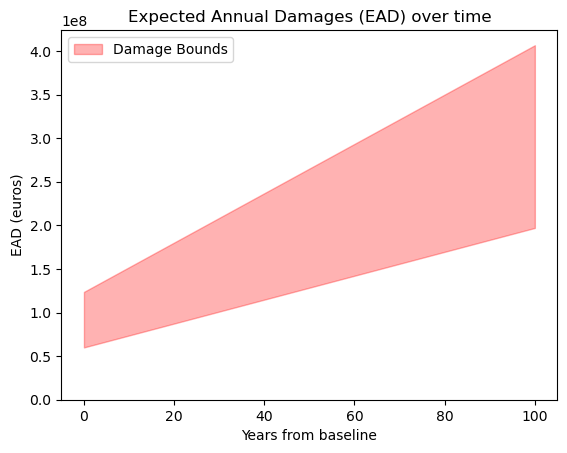

In [11]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': 2,
    '_M_': 6.6,
    '_L_': 9.1
} # https://hess.copernicus.org/preprints/hess-2016-65/hess-2016-65-manuscript-version2.pdf 

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = return_periods #TODO: make generic for other regions

# Add the return period column to aggregated_df and sort by return period
aggregated_df['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df.index]
aggregated_df = aggregated_df.sort_values('Return Period', ascending=True)

# Calculate the probability of each return period 
aggregated_df['Probability'] = [[1 / x for x in i] for i in aggregated_df['Return Period']]
probabilities = aggregated_df['Probability']
dmgs = []

# Calculate the expected annual damages for each time step using trapezoidal rule for integration
for ts in range(len(probabilities.iloc[0])):    
    dmgs_l = []
    dmgs_u = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
        trap_damage_l = 0.5 * (aggregated_df['Total Damage Lower Bound'].iloc[rp] + aggregated_df['Total Damage Lower Bound'].iloc[rp + 1])
        trap_damage_u = 0.5 * (aggregated_df['Total Damage Upper Bound'].iloc[rp] + aggregated_df['Total Damage Upper Bound'].iloc[rp + 1])
        dmgs_l.append(d_rp * trap_damage_l)
        dmgs_u.append(d_rp * trap_damage_u)
    
    # Add the portion of damages corresponding to the tails of the distribution
    # Assumption - considers the damage for return periods higher than the highest return period the same as that of the highest return period
    d0_rp = probabilities.iloc[-1][ts]
    damage_l0 = max(aggregated_df['Total Damage Lower Bound'])
    damage_u0 = max(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d0_rp * damage_l0)
    dmgs_u.append(d0_rp * damage_u0)

    # Assumption - considers that no assets are damaged at a return period of 4 years or lower
    d_end_rp = (1/4)-probabilities.iloc[0][ts]
    damage_l_end = 0.5 * min(aggregated_df['Total Damage Lower Bound'])
    damage_u_end = 0.5 * min(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d_end_rp * damage_l_end)
    dmgs_u.append(d_end_rp * damage_u_end)

    dmgs.append((sum(dmgs_l), sum(dmgs_u)))

ead_by_ts = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

print(f'Baseline expected annual damages: {dmgs[0][0]:,.2f} to {dmgs[0][1]:,.2f} EUR')
print(f'Expected annual damages without adaptation by year {num_years}: {dmgs[-1][0]:,.2f} to {dmgs[-1][1]:,.2f} EUR')

ead_by_ts_plot(ead_by_ts)

In [12]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

summed_output

{'flood_DERP_RW_H_4326_2080410170': (8660.346345429718, 13620.796027616947),
 'flood_DERP_RW_H_4326_2080410430': (37011.78449206103, 158149.38078075842),
 'flood_DERP_RW_H_4326_2080410540': (62528.33745818449, 62528.33745818449),
 'flood_DERP_RW_H_4326_2080410660': (0, 0),
 'flood_DERP_RW_H_4326_2080410760': (0, 0),
 'flood_DERP_RW_H_4326_2080411370': (119700.03477632943, 550561.56526837),
 'flood_DERP_RW_H_4326_2080416200': (0, 0),
 'flood_DERP_RW_H_4326_2080416210': (1481742.4683239164, 4403885.552981349),
 'flood_DERP_RW_H_4326_2080418600': (2929760.3940743627, 13970138.7681109),
 'flood_DERP_RW_H_4326_2080418720': (0, 0),
 'flood_DERP_RW_H_4326_2080418880': (111629.76363490838, 112759.18055462776),
 'flood_DERP_RW_H_4326_2080418890': (6545.432268332452, 17179.03757395942),
 'flood_DERP_RW_H_4326_2080419070': (0, 0),
 'flood_DERP_RW_H_4326_2080419180': (1444607.1537085557, 4803874.848097931),
 'flood_DERP_RW_H_4326_2080420240': (124273.27445898595, 341572.49978430034),
 'flood_DERP_

In [13]:
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in summed_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = summed_output[key]


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    
 


In [14]:
total_damage_lower_bound = ead_by_ts_by_basin[basins_list[0]]['Total Damage Lower Bound']
print(f'Baseline expected annual damages for basin {basins_list[0]}:{sum(total_damage_lower_bound):,.2f} EUR')
total_damage_upper_bound = ead_by_ts_by_basin[basins_list[0]]['Total Damage Upper Bound']
print(f'Baseline expected annual damages for basin {basins_list[0]}:{sum(total_damage_upper_bound):,.2f} EUR')


Baseline expected annual damages for basin 2080428160:293,783,372.13 EUR
Baseline expected annual damages for basin 2080428160:427,619,247.25 EUR


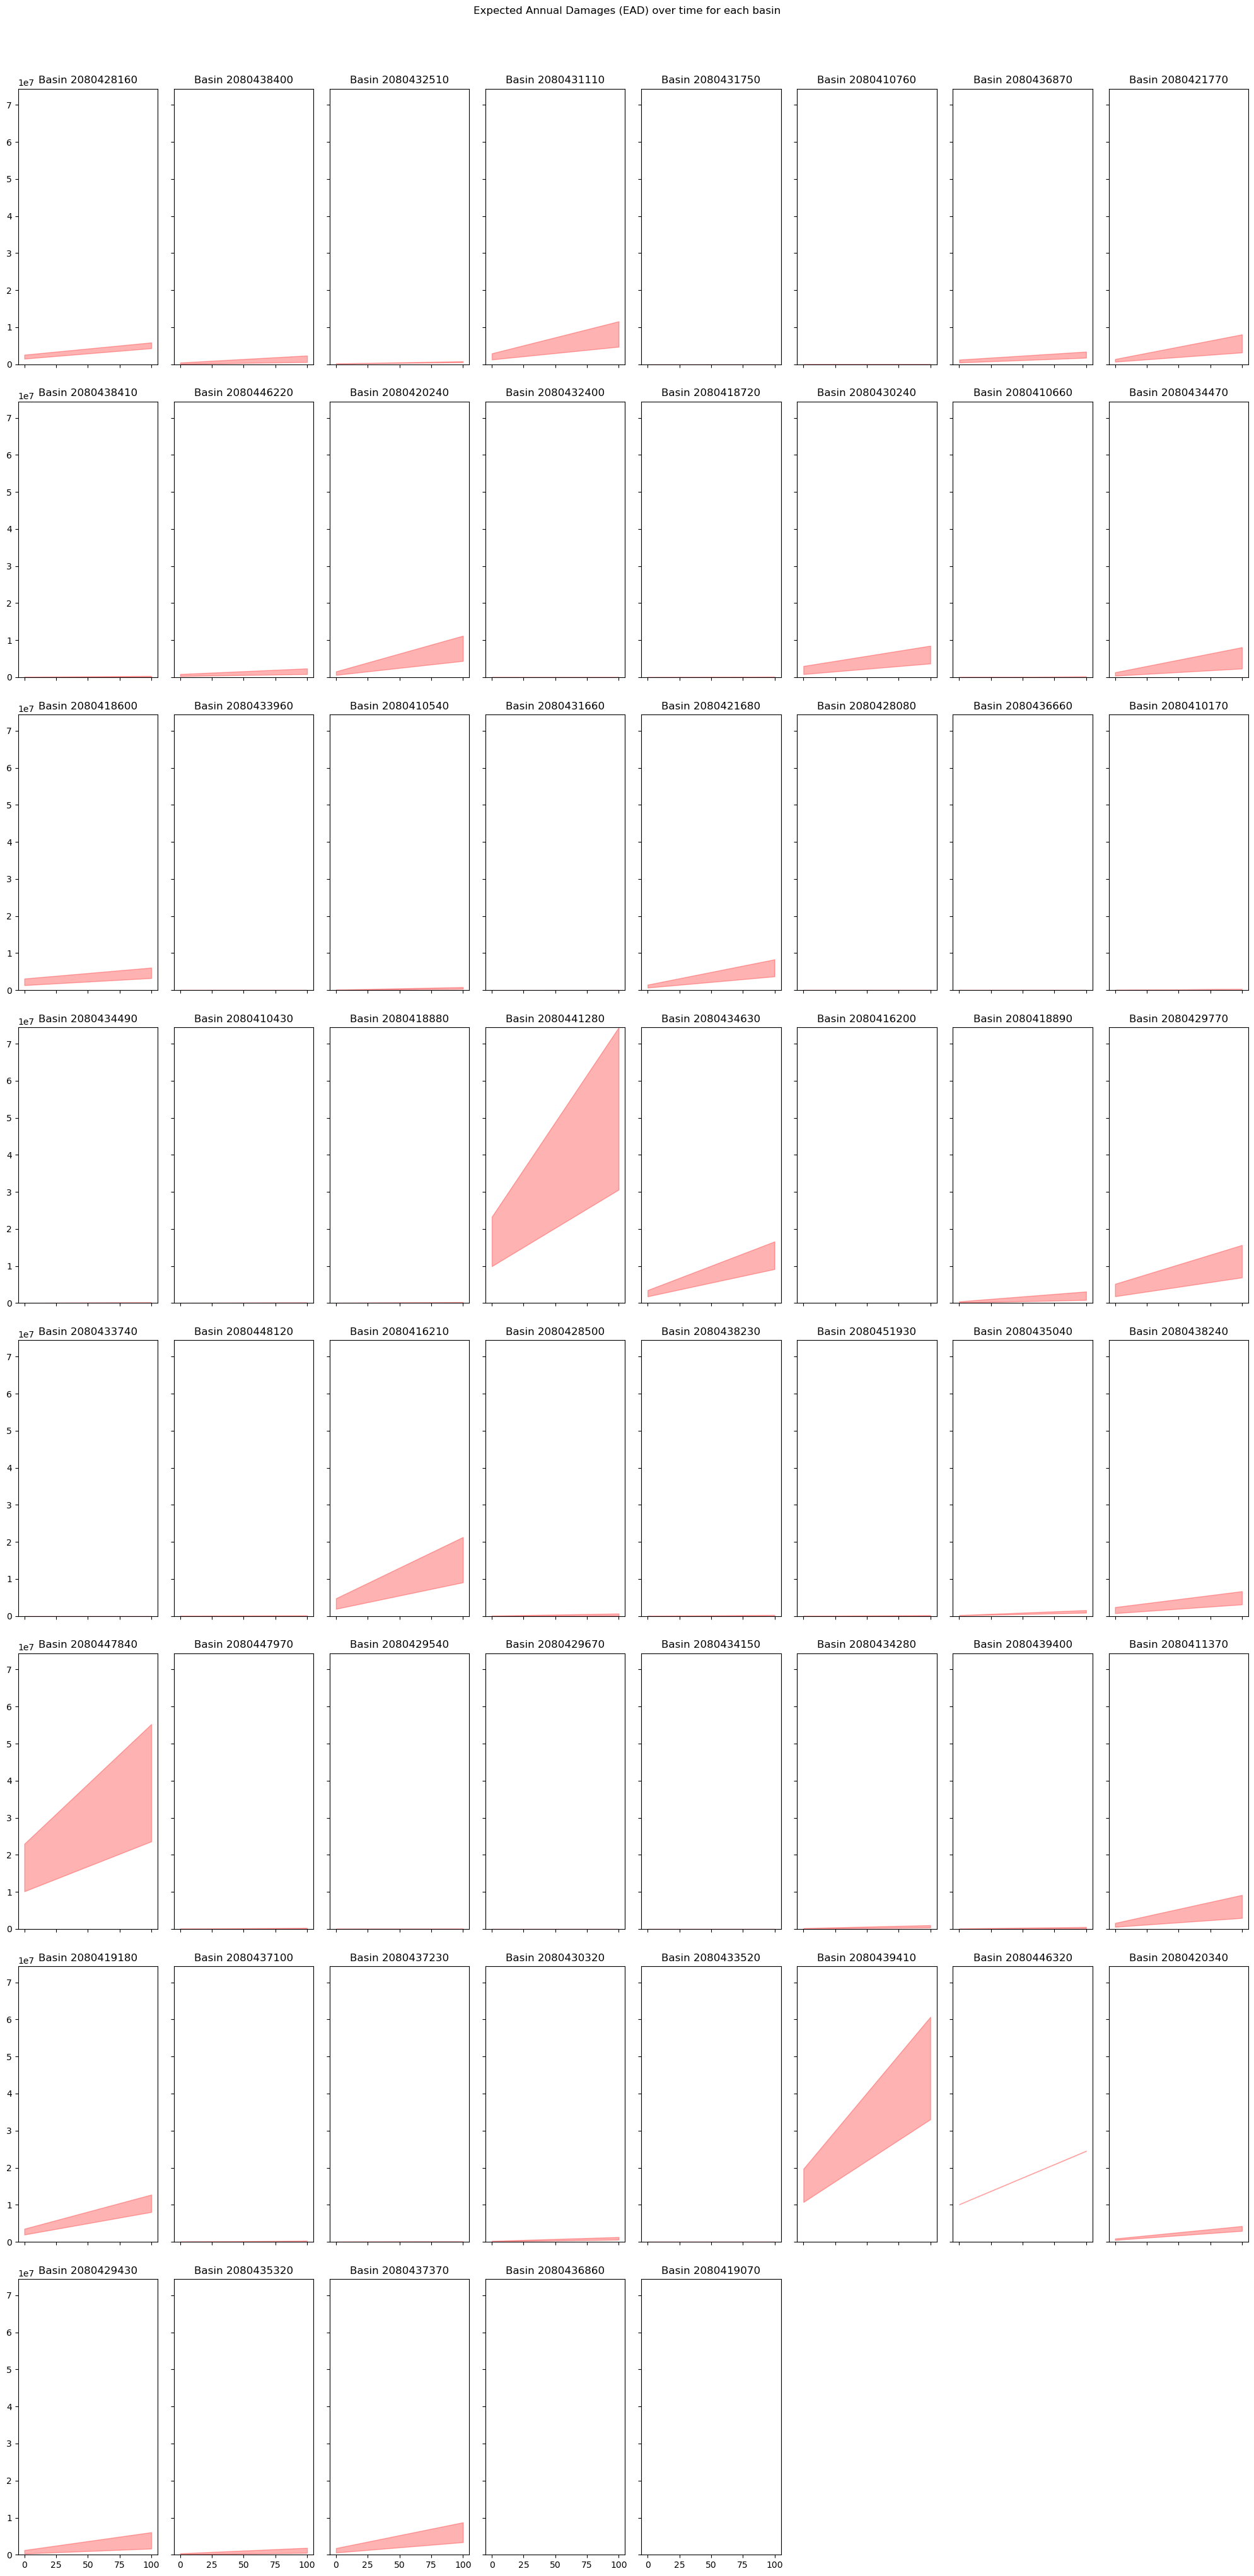

In [15]:
# Calculate the number of rows and columns based on the number of basins
num_basins = len(ead_by_ts_by_basin)
num_cols = int(np.ceil(np.sqrt(num_basins)))
num_rows = int(np.ceil(num_basins / num_cols))

# Create subplots with shared x-axis, the calculated number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array for easy iteration
axs = axs.flatten()

max_value = max([ead_by_ts_by_basin[basin]['Total Damage Upper Bound'].max() for basin in ead_by_ts_by_basin.keys()])

for i, basin in enumerate(ead_by_ts_by_basin.keys()):
    axs[i].fill_between(ead_by_ts_by_basin[basin].index, ead_by_ts_by_basin[basin]['Total Damage Lower Bound'], ead_by_ts_by_basin[basin]['Total Damage Upper Bound'], alpha=0.3, color='red')
    axs[i].set_title(f'Basin {basin}')
    axs[i].set_ylim(0, max_value)  # Set y-axis lower limit to 0 and upper limit to max_value

# Hide any unused axes
for j in range(num_basins, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.suptitle('Expected Annual Damages (EAD) over time for each basin', y=1.02)
plt.show()


In [17]:
with open(f'{interim_data_path}/ead_by_ts_by_basin_direct.pkl', 'wb') as f:
    pickle.dump(ead_by_ts_by_basin, f)

In [18]:
ead_by_ts_by_basin

{2080428160:      Total Damage Lower Bound  Total Damage Upper Bound
 0                1.502038e+06              2.582543e+06
 1                1.530172e+06              2.615569e+06
 2                1.558306e+06              2.648595e+06
 3                1.586440e+06              2.681621e+06
 4                1.614575e+06              2.714648e+06
 ..                        ...                       ...
 96               4.202918e+06              5.753060e+06
 97               4.231052e+06              5.786087e+06
 98               4.259186e+06              5.819113e+06
 99               4.287320e+06              5.852139e+06
 100              4.315455e+06              5.885165e+06
 
 [101 rows x 2 columns],
 2080438400:      Total Damage Lower Bound  Total Damage Upper Bound
 0                84698.452155              4.730290e+05
 1                89691.240347              4.918783e+05
 2                94684.028539              5.107276e+05
 3                99676.816731       